# Object-oriented-programmed Neural Network

#### Includes standard binary classification and softmax

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We define several classes :

- a "net" class that will be instantiated only once
```
net = Net('multi_cross_entropy')
```
- several "layer" classes, which will have to be instantiated Keras-style :
```
net.add(LayerFC(2,2))
net.add(LayerTanh())
net.add(LayerFC(2, 4))
net.add(LayerTanh())
net.add(LayerFC(4, 1))
net.add(LayerSigmoid())
```

In [27]:
class Net():
    
    def __init__(self, loss_type): # loss_type should be a string: 'bin_cross_entropy', 'multi_cross_entropy'...
        self.layers = []
        self.loss_type = loss_type
        
    def add(self, layer):
        self.layers.append(layer)
        
    def forward_pass(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A
        
    def bin_cross_entropy(self, A, Y):
        m = A.shape[1] #batch size
        loss = - (np.log(A) * Y + np.log(1 - A) * (1 - Y))
        cost = np.sum(loss) / m
        return cost
    
    def multi_cross_entropy(self, preds, labels):
        # preds: probabilities in a (nclasses, nexamples) array
        # labels: 1-0 in a (nclasses, nexamples) array (one-hot encoded)
        cross = np.multiply(preds, labels)
        cross = cross[cross != 0]
        cross = -np.log(cross)
        cross = np.mean(cross)
        return cross
        
    def backward_pass(self, dERROR, learning_rate):
        if self.loss_type == 'bin_cross_entropy':
            backward_list = reversed(self.layers)
        elif self.loss_type == 'multi_cross_entropy':
            backward_list = reversed(self.layers[0:-1])

        for layer in backward_list:
            dERROR = layer.backward(dERROR, learning_rate)
            
    def get_accuracy(self, A, Y):
        # get best-guess predictions
        preds = np.round(A, decimals=0)
        # check how many such guesses were right
        correct_preds = (Y == preds)
        n_correct = np.squeeze(np.sum(correct_preds))
        # get accuracy rate
        m = A.shape[1] # number of examples
        accuracy = n_correct / m
        return accuracy
       
    def train(self, X, Y, learning_rate, epochs, prints_freq):

        self.costs = []
        
        for epoch in range(epochs):
            A = self.forward_pass(X)
            
            if self.loss_type == 'bin_cross_entropy':
                dERROR = - (Y/A) + ((1-Y)/(1-A))  # at this point dERROR = dJ/dAL
                curr_cross_entropy = self.bin_cross_entropy(A, Y)            
            elif self.loss_type == 'multi_cross_entropy':
                dERROR = A - Y # at this point dERROR = dJ/dZ
                curr_cross_entropy = self.multi_cross_entropy(A, Y)            

            if epoch % prints_freq == 0:
                print("Epoch:", epoch, "Cost: ", curr_cross_entropy)
            self.costs.append(curr_cross_entropy)
            
            self.backward_pass(dERROR, learning_rate)
        plt.plot(self.costs)
        
    def translate(self, A):
        return np.argmax(A, axis = 0)

We define 
- One "Fully-Connected" layer class
- Several activation layer classes

In [28]:
class LayerFC():
    
    def __init__(self, n_x, n_h):
        self.W = np.random.randn(n_h, n_x)
        self.b = np.zeros((n_h, 1))
    
    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(self.W, self.A_prev) + self.b
        return self.Z
    
    def backward(self, dERROR, learning_rate):
        m = dERROR.shape[1] #batch size
        dW = (1 / m) * np.dot(dERROR, self.A_prev.T)
        db = (1 / m) * np.sum(dERROR, axis=1, keepdims=True)
        dERROR = np.dot(self.W.T, dERROR)
        
        self.W = self.W - learning_rate * dW        
        self.b = self.b - learning_rate * db        
        
        return dERROR
    
class LayerSigmoid():
    
    def forward(self, Z):
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    
    def backward(self, dERROR, learning_rate):
        derivative = self.A * (1 - self.A)
        dERROR = dERROR * derivative        
        return dERROR

class LayerTanh():    
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A
    
    def backward(self, dERROR, learning_rate):
        derivative = 1 - np.square(self.A)
        dERROR = dERROR * derivative
        return dERROR

#ReLU doesn't seem to deliver even remotely correct perfs with our simple datasets.
    
class LayerSoftmax():    
    def forward(self, Z):
        self.t = np.exp(Z)
        exps_sum = np.sum(self.t)
        self.A = self.t / exps_sum
        return self.A

    def backward(self, dERROR, learning_rate):
        derivative = self.A * (1 - self.A)
        dERROR = dERROR * derivative        
        return dERROR


#### Generating examples

In [29]:
def gen_xor_examples(sample_size):
    X = np.random.randn(2,sample_size)
    mask1 = X[0, :] > 0
    mask2 = X[1, :] > 0
    mask3 = X[0, :] < 0
    mask4 = X[1, :] < 0
    Y = ((mask1 & mask2) | (mask3 & mask4)) * 1
    Y = Y.reshape(1, Y.shape[0])
    return X, Y

In [30]:
X_train, Y_train = gen_xor_examples(500)
X_test, Y_test = gen_xor_examples(100)

In [38]:
#net = Net('multi_cross_entropy')
net = Net('bin_cross_entropy')
net.add(LayerFC(2,2))
net.add(LayerTanh())
net.add(LayerFC(2, 4))
net.add(LayerTanh())
net.add(LayerFC(4, 1))
net.add(LayerSigmoid())

Epoch: 0 Cost:  0.714097224639183
Epoch: 500 Cost:  0.041569019597725625
Epoch: 1000 Cost:  0.018059910073515317


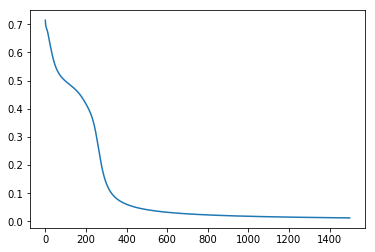

In [39]:
net.train(X_train, Y_train, epochs=1500, learning_rate=0.5, prints_freq=500)